# Analyse thématique-RC

In [1]:
import os
import pandas as pd
from tqdm.auto import tqdm
from Data_collection_ALL import search_key

In [2]:
def PO_collection(file_dir):
    all_files_list = os.listdir(file_dir)
    tracing_files = [i for i in all_files_list if os.path.isfile(os.path.join(file_dir,i)) and i.startswith('tracing')]
    liste_po = []
    liste_rma = []
    for file in tqdm(tracing_files):
        single_tracing = pd.read_excel(os.path.join(file_dir, file), sheet_name='txn history')
        single_tracing_rma = pd.read_excel(os.path.join(file_dir, file), sheet_name='Summary', index_col=0)

        df_PO = single_tracing[['Transaction Sub-Type', 'PO Number', 'Job Number']]
        po = df_PO[df_PO['Transaction Sub-Type'].str.contains('RDE Repair')]['PO Number']
        if len(po)==0:
            po = df_PO[df_PO['Transaction Sub-Type'].str.contains('GPO Repair')]['Job Number']
        try:
            po_val = po.values[0]
        except:
            # print(file)
            po_val = None
        liste_po.append(po_val)

        rma = single_tracing_rma.loc['Key_value', 'Values']
        liste_rma.append(rma)
        # print(file, po_val, rma)
    return liste_po, liste_rma

In [3]:
file_dir = '../Analyse_RC_2416759-R/RMA_forward/'
liste_po, liste_rma = PO_collection(file_dir)

  0%|          | 0/978 [00:00<?, ?it/s]

In [4]:
rma_po = pd.DataFrame()
rma_po['Forward_rma'] = liste_rma
rma_po['PO'] = liste_po
rma_po.to_excel('../Analyse_RC_2416759-R/rma_po.xlsx')

In [5]:
def Vendor_collection(file_dir):
    all_files_list = os.listdir(file_dir)
    tracing_files = [i for i in all_files_list if os.path.isfile(os.path.join(file_dir,i)) and i.startswith('tracing')]
    liste_vendor = []
    liste_po = []
    for file in tqdm(tracing_files):
        single_tracing = pd.read_excel(os.path.join(file_dir, file), sheet_name='repair history')
        single_tracing_po = pd.read_excel(os.path.join(file_dir, file), sheet_name='Summary', index_col=0)
        if len(single_tracing.index)!=0:
            df_Repair_site = single_tracing['Vendor Site Code'].tolist()
            Repair_site = df_Repair_site[0]
        else:
            Repair_site = pd.NA
        liste_vendor.append(Repair_site)

        po = single_tracing_po.loc['Key_value', 'Values']
        liste_po.append(po)
        # print(file, po_val, rma)
    return liste_vendor, liste_po

In [6]:
file_dir = '../Analyse_RC_2416759-R/PO_forward/'
liste_vendor, liste_po = Vendor_collection(file_dir)

  0%|          | 0/537 [00:00<?, ?it/s]

In [7]:
po_vendor = pd.DataFrame()
po_vendor['PO'] = liste_po
po_vendor['RC'] = liste_vendor
# po_vendor[po_vendor['PO']=='425618']

In [8]:
# 
po_vendor['PO']=po_vendor['PO'].astype(str)
po_vendor['PO'] = po_vendor['PO'].apply(lambda x: x[:-2] if x.endswith('.0') else x)
# po_vendor[po_vendor['PO']=='760197659']

In [9]:
rma_po['PO'] = rma_po['PO'].astype(str)
rma_po['PO'] = rma_po['PO'].apply(lambda x: x[:-2] if x.endswith('.0') else x)
# liste = []
# for s in rma_po['PO'].tolist():
#     if s.endswith('.0'):
#         liste.append(s[:-2])
#     else:
#         liste.append(s)
# rma_po['PO']=liste

In [10]:
rma_po[rma_po['PO']!='None']


,Forward_rma,PO
0,112851574,73320980
1,119669066,301883935
3,122527049,760110534
5,124693434,600814076
7,126867755,760110051
...,...,...
967,360147034,760223835
969,360378355,760225328
972,361126707,760225169
973,361137050,760225168


In [11]:
rma_po[rma_po['PO']=='301685189']

,Forward_rma,PO


In [12]:
merge = rma_po.merge(po_vendor, how='left', left_on='PO', right_on='PO')
merge[merge['PO']=='425618']


,Forward_rma,PO,RC


In [13]:
data_SS = pd.read_excel('../Analyse_RC_2416759-R/SS.xlsx')
data_SS.loc[data_SS['elf_days']==0, 'adjusted_earlylife_failure']='FOA'
data_SS.loc[(data_SS['elf_days']>0) & (data_SS['elf_days']<180), 'adjusted_earlylife_failure']='ELF'
data_SS.loc[data_SS['elf_days']>=180, 'adjusted_earlylife_failure']='IPFR>180'

failure = data_SS[['adjusted_earlylife_failure', 'rma_no']]

In [14]:
failure['rma_no'] = failure['rma_no'].astype(str)
failure['rma_no'] = failure['rma_no'].apply(lambda x: x[:-2] if x.endswith('.0') else x)

C:\Users\223102584\AppData\Local\Temp\ipykernel_23428\2296836629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure['rma_no'] = failure['rma_no'].astype(str)
C:\Users\223102584\AppData\Local\Temp\ipykernel_23428\2296836629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure['rma_no'] = failure['rma_no'].apply(lambda x: x[:-2] if x.endswith('.0') else x)


In [15]:
merge['Forward_rma'] = merge['Forward_rma'].astype(str)
final = failure.merge(merge, how='left', left_on='rma_no', right_on='Forward_rma')

In [16]:
final[final['RC'].isna()==False].head(15)
final[final['RC']=='GPO REPAIR 503']

,adjusted_earlylife_failure,rma_no,Forward_rma,PO,RC


In [17]:
final.to_excel('../Analyse_RC_2416759-R/final.xlsx')

In [18]:
dist = final[['adjusted_earlylife_failure', 'RC', 'rma_no']]
dist.dropna(subset=['RC'], inplace=True)
group_dist = dist.groupby(['RC','adjusted_earlylife_failure']).count()
group_dist

C:\Users\223102584\AppData\Local\Temp\ipykernel_23428\383861224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist.dropna(subset=['RC'], inplace=True)


rma_no
RC              adjusted_earlylife_failure        
AURORA      102 ELF                             52
                FOA                             24
                IPFR>180                       225
BARUERI     105 ELF                              1
                IPFR>180                         4
GPO ASIA    511 FOA                              1
                IPFR>180                         7
SHANGHAI    101 ELF                             47
                FOA                             13
                IPFR>180                       155
Tianjin 101     IPFR>180                        11

In [23]:
print('taux de IPFR>180 à AURORA:{:.2f}'.format(225/(52+24+225)*100),'%' )
print('taux de IPFR>180 à SHANGHAI:{:.2f}'.format(155/(47+13+155)*100), '%')

print('taux de FOA à AURORA:{:.2f}'.format(24/(52+24+225)*100), '%')
print('taux de FOA à SHANGHAI:{:.2f}'.format(13/(47+13+155)*100), '%')

taux de IPFR>180 à AURORA:74.75 %
taux de IPFR>180 à SHANGHAI:72.09 %
taux de FOA à AURORA:7.97 %
taux de FOA à SHANGHAI:6.05 %


In [ ]:
def index(group_dist):
    """_summary_

    Parameters
    ----------
    group_dist : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    return group_dist.index

<Axes: xlabel='RC'>

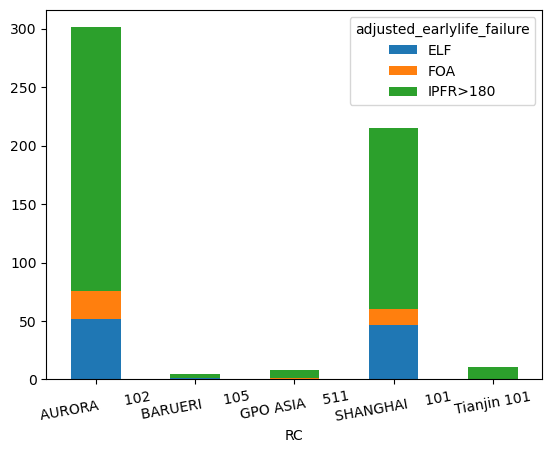

In [22]:
group_dist = dist.groupby(['RC','adjusted_earlylife_failure']).count().unstack()
group_dist.columns = group_dist.columns.droplevel()
group_dist.plot.bar(stacked = True, rot=10)


In [23]:
group_dist

adjusted_earlylife_failure,ELF,FOA,IPFR>180
RC,,,
AURORA 102,20,14,84
SHANGHAI 101,11,12,24


In [206]:
file_dir = '../Analyse_RC_2418093/RMA_forward/'
liste_po, liste_rma = PO_collection(file_dir)

  0%|          | 0/1346 [00:00<?, ?it/s]

In [207]:
rma_po = pd.DataFrame()
rma_po['Forward_rma'] = liste_rma
rma_po['PO'] = liste_po
rma_po.to_excel('../Analyse_RC_2418093/rma_po.xlsx')

In [210]:
file_dir = '../Analyse_RC_2418093/PO_forward/'
liste_vendor, liste_po = Vendor_collection(file_dir)

  0%|          | 0/739 [00:00<?, ?it/s]

In [211]:
po_vendor = pd.DataFrame()
po_vendor['PO'] = liste_po
po_vendor['RC'] = liste_vendor
po_vendor

,PO,RC
0,301639988,AURORA 102
1,301641695,AURORA 102
2,301659247,AURORA 102
3,301660176,AURORA 102
4,301661734,AURORA 102
...,...,...
734,760221236,Tianjin 101
735,760221781,Tianjin 101
736,760221782,SHANGHAI 101
737,760222385,Tianjin 101


In [212]:
po_vendor['PO']=po_vendor['PO'].astype(str)
po_vendor['PO'] = po_vendor['PO'].apply(lambda x: x[:-2] if x.endswith('.0') else x)

In [213]:
rma_po['PO'] = rma_po['PO'].astype(str)
rma_po['PO'] = rma_po['PO'].apply(lambda x: x[:-2] if x.endswith('.0') else x)

In [214]:
merge = rma_po.merge(po_vendor, how='left', left_on='PO', right_on='PO')
# merge[merge['PO']=='760197659']

In [215]:
data_SS = pd.read_excel('../Analyse_RC_2418093/SS.xlsx')
data_SS.loc[data_SS['elf_days']==0, 'adjusted_earlylife_failure']='FOA'
data_SS.loc[(data_SS['elf_days']>0) & (data_SS['elf_days']<180), 'adjusted_earlylife_failure']='ELF'

failure = data_SS[['adjusted_earlylife_failure', 'rma_no']]

In [216]:
failure['rma_no'] = failure['rma_no'].astype(str)
failure['rma_no'] = failure['rma_no'].apply(lambda x: x[:-2] if x.endswith('.0') else x)

C:\Users\223102584\AppData\Local\Temp\ipykernel_15040\2296836629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure['rma_no'] = failure['rma_no'].astype(str)
C:\Users\223102584\AppData\Local\Temp\ipykernel_15040\2296836629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure['rma_no'] = failure['rma_no'].apply(lambda x: x[:-2] if x.endswith('.0') else x)


In [217]:
merge['Forward_rma'] = merge['Forward_rma'].astype(str)
final = failure.merge(merge, how='left', left_on='rma_no', right_on='Forward_rma')

In [219]:
final.isna().sum()

adjusted_earlylife_failure      0
rma_no                          0
Forward_rma                   208
PO                            208
RC                            816
dtype: int64

In [221]:
final.to_excel('../Analyse_RC_2418093/final.xlsx')

In [222]:
dist = final[['adjusted_earlylife_failure', 'RC', 'rma_no']]
dist.dropna(subset=['RC'], inplace=True)
group_dist = dist.groupby(['RC','adjusted_earlylife_failure']).count()
group_dist

C:\Users\223102584\AppData\Local\Temp\ipykernel_15040\383861224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist.dropna(subset=['RC'], inplace=True)


rma_no
RC              adjusted_earlylife_failure        
AURORA      102 ELF                             65
                FOA                             35
                IPFR>180                       331
GPO ASIA    511 ELF                              1
                IPFR>180                         6
SHANGHAI    101 ELF                             81
                FOA                             24
                IPFR>180                       191
Tianjin 101     IPFR>180                         6

In [224]:
print('taux de IPFR>180 à AURORA:{:.2f}'.format(331/(65+35+331)*100),'%' )
print('taux de IPFR>180 à SHANGHAI:{:.2f}'.format(191/(81+24+191)*100), '%')

print('taux de FOA à AURORA:{:.2f}'.format(35/(65+35+331)*100), '%')
print('taux de FOA à SHANGHAI:{:.2f}'.format(24/(81+24+191)*100), '%')

taux de IPFR>180 à AURORA:76.80 %
taux de IPFR>180 à SHANGHAI:64.53 %
taux de FOA à AURORA:8.12 %
taux de FOA à SHANGHAI:8.11 %


<Axes: xlabel='RC'>

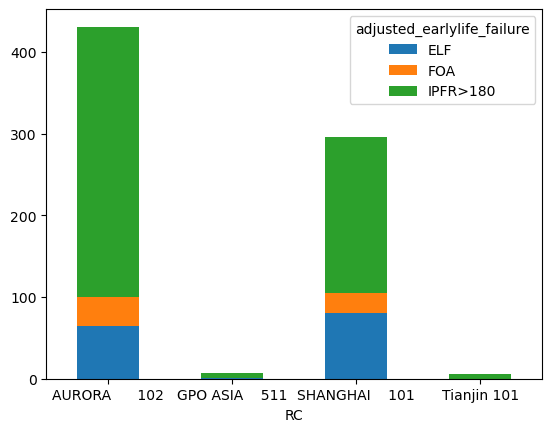

In [223]:
group_dist = dist.groupby(['RC','adjusted_earlylife_failure']).count().unstack()
group_dist.columns = group_dist.columns.droplevel()
group_dist.plot.bar(stacked = True, rot=0)

# *Prime*

In [15]:
data = pd.read_excel('../Analyse_Prime_probe/SS_4_classes.xlsx')

In [16]:
dist = data[['adjusted_earlylife_failure', 'failed_part_supplier_site_code', 'failed_part_no']]
dist.dropna(subset=['failed_part_supplier_site_code'], inplace=True)
group_dist = dist.groupby(['failed_part_supplier_site_code','adjusted_earlylife_failure']).count()
group_dist

C:\Users\223102584\AppData\Local\Temp\ipykernel_19296\1798255905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist.dropna(subset=['failed_part_supplier_site_code'], inplace=True)


failed_part_no
failed_part_supplier_site_code adjusted_earlylife_failure                
AURORA      102                ELF                                     33
                               FOA                                     22
                               IPFR180                                105
BAOTOU      101                ELF                                      1
BEST        105                ELF                                     37
                               FOA                                     24
                               IPFR180                                206
BROOKLYN PAR102                FOA                                      3
                               IPFR180                                  4
CHANDLER    104                ELF                                      1
COCHIN      101                ELF                                     24
                               FOA                                      4
                               IPFR180                                 79
FENTON      101                ELF                                      3
                               IPFR180                                 24
HARTLAND    106                ELF                                      1
                               FOA                                      2
                               IPFR180                                  6
IBS F39000 -LTB                FOA                                      1
                               IPFR180                                  1
MINNETONKA  101                ELF                                      1
                               IPFR180                                  2
PEWAUKEE    101                ELF                                    159
                               FOA                                    127
                               IPFR180                                407
PITTSBURGH  101                IPFR180                                  1
RIMPAR      102                FOA                                      1
SHENZHEN    102                ELF                                      9
                               FOA                                     13
                               IPFR180                                 72
WAUKESHA    101                IPFR180                                  1
WAUKESHA    105                ELF                                      6
                               FOA                                      6
                               IPFR180                                 24
WHEELING    101                IPFR180                                  1
WUXI  102                      ELF                                      1
XIAMEN      101                ELF                                      8
                               FOA                                      5
                               IPFR180                                  7

<Axes: xlabel='failed_part_supplier_site_code'>

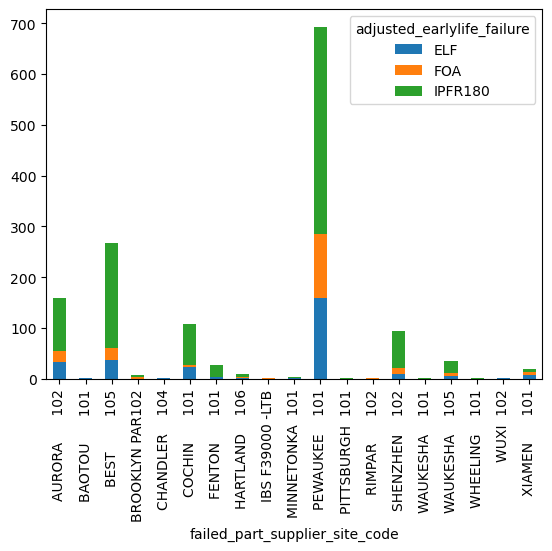

In [17]:
group_dist = dist.groupby(['failed_part_supplier_site_code','adjusted_earlylife_failure']).count().unstack()
group_dist.columns = group_dist.columns.droplevel()
group_dist.plot.bar(stacked = True, rot=90)

In [18]:
df = group_dist.sum(axis=1)
group_dist['ratio'] = group_dist['FOA']/df

In [19]:
group_dist

adjusted_earlylife_failure,ELF,FOA,IPFR180,ratio
failed_part_supplier_site_code,,,,
AURORA 102,33.0,22.0,105.0,0.137500
BAOTOU 101,1.0,NaN,NaN,NaN
BEST 105,37.0,24.0,206.0,0.089888
BROOKLYN PAR102,NaN,3.0,4.0,0.428571
CHANDLER 104,1.0,NaN,NaN,NaN
COCHIN 101,24.0,4.0,79.0,0.037383
FENTON 101,3.0,NaN,24.0,NaN
HARTLAND 106,1.0,2.0,6.0,0.222222
IBS F39000 -LTB,NaN,1.0,1.0,0.500000


In [25]:
dist2 = group_dist.dropna()
dist2

adjusted_earlylife_failure,ELF,FOA,IPFR180,ratio
failed_part_supplier_site_code,,,,
AURORA 102,33.0,22.0,105.0,0.137500
BEST 105,37.0,24.0,206.0,0.089888
COCHIN 101,24.0,4.0,79.0,0.037383
HARTLAND 106,1.0,2.0,6.0,0.222222
PEWAUKEE 101,159.0,127.0,407.0,0.183261
SHENZHEN 102,9.0,13.0,72.0,0.138298
WAUKESHA 105,6.0,6.0,24.0,0.166667
XIAMEN 101,8.0,5.0,7.0,0.250000


<Axes: xlabel='failed_part_supplier_site_code'>

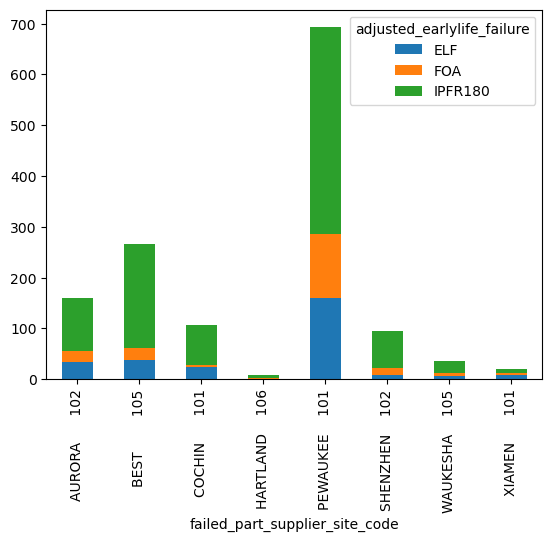

In [24]:
dist2.drop(columns='ratio').plot.bar(stacked = True, rot=90)